In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

<ipython-input-4-d3dd355f8edb>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/childes_individuals-all-seqs.pickle')

In [6]:
len(MI_DF)

1751

In [7]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,dataset,xml_loc,n_words,words_list,PID
0,"[5.762224226229021, 5.572383552919533, 5.43205...","[0.05431588977013128, 0.05373986314362249, 0.0...","[4.857793149755494, 4.820736348866696, 4.84918...","[0.05175324022306115, 0.05162768350813497, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,1409,198,P1Y06M00D,Brown,[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,741,"[more, cookie, more, cookie, more, juice, Fras...",11312/c-00034743-1
1,"[5.787776843069089, 5.680026585718531, 5.59166...","[0.0597637314432635, 0.05903854294976535, 0.05...","[5.295467743053678, 5.316546532627299, 5.30676...","[0.0572531813008798, 0.05731385669073913, 0.05...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,825,185,P1Y06M00D,Brown,[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,473,"[one, two, three, one, two, three, two, one, t...",11312/c-00034744-1
2,"[6.227731814095765, 6.00053901867944, 5.909387...","[0.07534186725765339, 0.07398325539722597, 0.0...","[5.340086236211851, 5.3302887206213665, 5.3211...","[0.06906354179316766, 0.06941713524403077, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,465,128,P1Y01M,Normal,[/mnt/cube/tsainbur/Projects/github_repos/LRSO...,423,"[tape, recorder, tape, recorder, daddy, daddy,...",11312/c-00004361-1


In [8]:
MI_DF.age_cohort_low.unique()

array([1, 1.5, 2, 2.5, 3], dtype=object)

In [9]:
age_cohorts = [[1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [10]:
MI_DF_list = []
for [ac_low, ac_high] in age_cohorts:
    MI_DF_list.append(MI_DF[MI_DF.age_cohort_low == ac_low])
MI_DF = pd.concat(MI_DF_list)

In [11]:
len(MI_DF)

1751

In [12]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [13]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    dist_mask = distances < 100
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan
    
    
    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

  0%|          | 0/1751 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/childes-paper/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/mnt/cube/tsainbur/Projects/github_repos/LRSO_paper_rev/LongRangeSequentialOrgPaper/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))
/mnt/cube/tsainbur/Projects/github_repos/LRSO_paper_rev/LongRangeSequentialOrgPaper/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: divide by zero encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


In [14]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[5.762224226229021, 5.572383552919533, 5.43205...","[0.05431588977013128, 0.05373986314362249, 0.0...","[4.857793149755494, 4.820736348866696, 4.84918...","[0.05175324022306115, 0.05162768350813497, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,1409,198,P1Y06M00D,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.960200,0.979830,0.977447,-624.016860,-686.910180,-680.251024,pow_exp,"[-1.8558774918456763e-06, -2.786230728327519e-...",97.0
1,"[5.787776843069089, 5.680026585718531, 5.59166...","[0.0597637314432635, 0.05903854294976535, 0.05...","[5.295467743053678, 5.316546532627299, 5.30676...","[0.0572531813008798, 0.05731385669073913, 0.05...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,825,185,P1Y06M00D,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.883165,0.898687,0.896692,-499.366396,-509.086512,-511.548221,pow,"[1.1604785897971335e-06, 1.742003777930566e-06...",NaN
2,"[6.227731814095765, 6.00053901867944, 5.909387...","[0.07534186725765339, 0.07398325539722597, 0.0...","[5.340086236211851, 5.3302887206213665, 5.3211...","[0.06906354179316766, 0.06941713524403077, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,465,128,P1Y01M,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.952983,0.954580,0.949720,-750.960688,-749.989340,-744.318612,exp,"[-2.0939386951647566e-06, -3.1411821985151647e...",NaN


In [15]:
true_n_words = [len(row.words_list) for idx, row in MI_DF.iterrows()]
MI_DF['n_words'] = true_n_words

In [16]:
MI_DF[MI_DF.dataset=='Gillam'][['n_words']][:3]

,n_words
1021,1511
1086,1340
1132,1438


In [17]:
{i:np.sum(MI_DF.bestfitmodel ==i) for i in MI_DF.bestfitmodel.unique()}

{'pow_exp': 111, 'pow': 602, 'exp': 1038}

In [18]:
PID_DF = pd.read_pickle(DATA_DIR/'mi/childes_word_prop.pickle')

In [19]:
MI_DF_pid = MI_DF.merge(PID_DF)

In [20]:
MI_DF_pid.to_pickle(DATA_DIR/'mi/childes_individuals-all-seqs-fit.pickle')

In [21]:
MI_DF_pid.iloc[0]

MI                 [5.762224226229021, 5.572383552919533, 5.43205...
MI_var             [0.05431588977013128, 0.05373986314362249, 0.0...
shuff_MI           [4.857793149755494, 4.820736348866696, 4.84918...
shuff_MI_var       [0.05175324022306115, 0.05162768350813497, 0.0...
distances          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
age_cohort_low                                                     1
age_cohort_high                                                  1.5
n_phones                                                        1409
n_unique_phones                                                  198
age                                                        P1Y06M00D
dataset                                                        Brown
xml_loc            [/mnt/cube/tsainbur/Projects/github_repos/LRSO...
n_words                                                         1409
words_list         [more, cookie, more, cookie, more, juice, Fras...
PID                               

In [22]:
MI_DF_pid.iloc[0].concat_results

In [23]:
MI_DF_pid['e_init'] = [row.concat_results.params['e_init'].value for idx, row in MI_DF_pid.iterrows()]
MI_DF_pid['e_decay_const'] = [row.concat_results.params['e_decay_const'].value for idx, row in MI_DF_pid.iterrows()]
MI_DF_pid['p_init'] = [row.concat_results.params['p_init'].value for idx, row in MI_DF_pid.iterrows()]
MI_DF_pid['p_decay_const'] = [row.concat_results.params['p_decay_const'].value for idx, row in MI_DF_pid.iterrows()]
MI_DF_pid['intercept'] = [row.concat_results.params['intercept'].value for idx, row in MI_DF_pid.iterrows()]

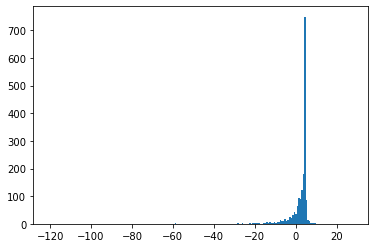

In [24]:
plt.hist(np.array(MI_DF.AICc_concat - MI_DF.AICc_exp), bins = 200);

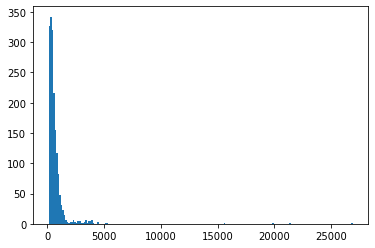

In [25]:
plt.hist(np.array(MI_DF.n_words), bins = 200);

In [26]:
import seaborn as sns

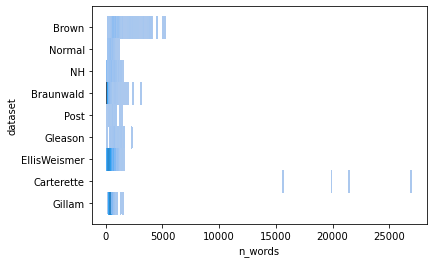

In [27]:
fig, ax = plt.subplots()
sns.histplot(MI_DF, x = 'n_words', y = "dataset", ax = ax);

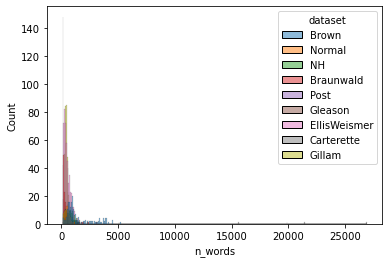

In [28]:
fig, ax = plt.subplots()
sns.histplot(MI_DF, x = 'n_words', hue = "dataset", ax = ax);

In [29]:
from scipy.stats import pearsonr

In [30]:
import seaborn as sns

In [31]:
MI_DF_pid.iloc[0]

MI                 [5.762224226229021, 5.572383552919533, 5.43205...
MI_var             [0.05431588977013128, 0.05373986314362249, 0.0...
shuff_MI           [4.857793149755494, 4.820736348866696, 4.84918...
shuff_MI_var       [0.05175324022306115, 0.05162768350813497, 0.0...
distances          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
age_cohort_low                                                     1
age_cohort_high                                                  1.5
n_phones                                                        1409
n_unique_phones                                                  198
age                                                        P1Y06M00D
dataset                                                        Brown
xml_loc            [/mnt/cube/tsainbur/Projects/github_repos/LRSO...
n_words                                                         1409
words_list         [more, cookie, more, cookie, more, juice, Fras...
PID                               

In [32]:
MI_DF_pid['delta_aic'] = np.min([MI_DF_pid['AICc_concat'], MI_DF_pid['AICc_power']],axis=0) -  MI_DF_pid['AICc_exp']

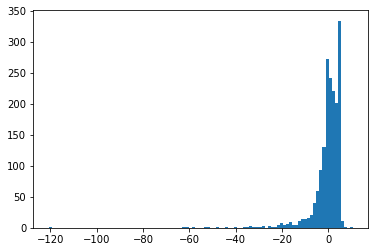

In [33]:
plt.hist(MI_DF_pid['delta_aic'].values, bins=100);

In [34]:
c = MI_DF.dataset.values
pal = sns.color_palette('Set1', len(np.unique(c)))
pal_dict = {i:p for i, p in zip(np.unique(c), pal)}
c_list = [pal_dict[i] for i in c]
np.unique(c)

array(['Braunwald', 'Brown', 'Carterette', 'EllisWeismer', 'Gillam',
       'Gleason', 'NH', 'Normal', 'Post'], dtype=object)

In [35]:
pal

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

(-0.015504408422938015, 0.5167541458349627)


Text(0.5, 0, '# words')

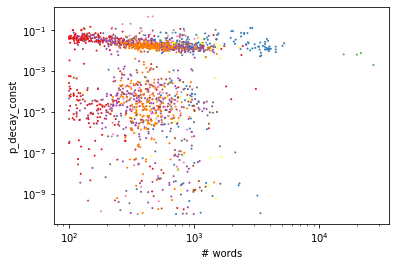

In [36]:
fig, ax = plt.subplots()
x = np.array(MI_DF_pid.n_words.values).astype(float)
y = np.array(MI_DF_pid.intercept)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = c_list);
#ax.set_ylim([-10,10])
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('p_decay_const')
ax.set_xlabel('# words')

(-0.35769288307623215, 5.386012909431039e-54)


Text(0.5, 0, '# words')

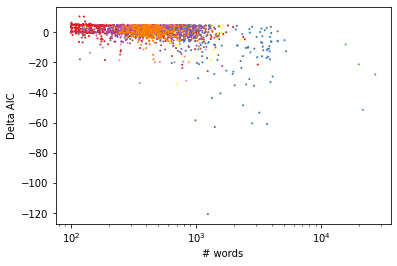

In [37]:
fig, ax = plt.subplots()
x = np.array(MI_DF_pid.n_words.values).astype(float)
y = np.array(MI_DF_pid.delta_aic)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = c_list);
#ax.set_ylim([-10,10])
ax.set_xscale('log')
#ax.set_yscale('symlog')

ax.set_ylabel('Delta AIC')
ax.set_xlabel('# words')

(-0.010192696903334707, 0.6809204777431641)


Text(0.5, 0, 'Prop words by child')

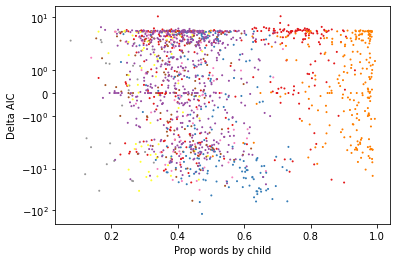

In [38]:
fig, ax = plt.subplots()
mask = MI_DF_pid.word_prop < 1
x = np.array(MI_DF_pid[mask].word_prop.values).astype(float)
y = np.array(MI_DF_pid[mask].delta_aic)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
#ax.set_xscale('log')
ax.set_yscale('symlog')

ax.set_ylabel('Delta AIC')
ax.set_xlabel('Prop words by child')

(0.052909060126892664, 0.03268197331189939)


Text(0.5, 0, 'Prop words by child')

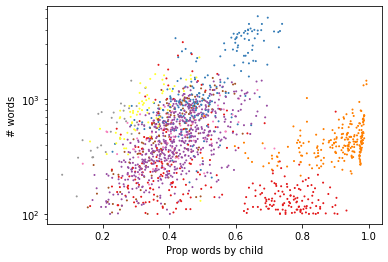

In [39]:
fig, ax = plt.subplots()
mask = MI_DF_pid.word_prop < 1
x = np.array(MI_DF_pid[mask].word_prop.values).astype(float)
y = np.array(MI_DF_pid[mask].n_words.values)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
ax.set_yscale('log')
#ax.set_yscale('symlog')

ax.set_ylabel('# words')
ax.set_xlabel('Prop words by child')

(0.057697872401851764, 0.01575023940048274)


Text(0.5, 0, 'Prop words by child')

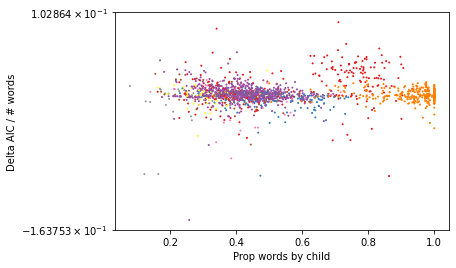

In [40]:
fig, ax = plt.subplots()
mask = MI_DF_pid.word_prop < 10
x = np.array(MI_DF_pid[mask].word_prop.values).astype(float)
y = np.array(MI_DF_pid[mask].delta_aic) / np.array(MI_DF_pid[mask].n_words.values).astype(float)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
ax.set_yscale('symlog')
ax.set_ylabel('Delta AIC / # words')
ax.set_xlabel('Prop words by child')

In [41]:
MI_DF.iloc[0].concat_results

In [42]:
MI_DF.iloc[0].concat_results.params

name,value,initial value,min,max,vary
e_init,0.60260806,0.5,1.0000e-19,inf,True
e_decay_const,0.46914351,0.1,1.0000e-10,inf,True
p_init,0.53987587,0.5,1.0000e-10,inf,True
p_decay_const,-0.19144110,-0.5,-inf,-1.0000e-10,True
intercept,9.0296e-06,1e-05,1.0000e-10,inf,True


### model 

In [43]:
MI_DF_pid[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,...,min_peak,child_words,total_words,word_prop,e_init,e_decay_const,p_init,p_decay_const,intercept,delta_aic
0,"[5.762224226229021, 5.572383552919533, 5.43205...","[0.05431588977013128, 0.05373986314362249, 0.0...","[4.857793149755494, 4.820736348866696, 4.84918...","[0.05175324022306115, 0.05162768350813497, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,1409,198,P1Y06M00D,...,97.0,741,1588,0.466625,0.602608,0.469144,0.539876,-0.191441,0.000009,-62.893320
1,"[5.787776843069089, 5.680026585718531, 5.59166...","[0.0597637314432635, 0.05903854294976535, 0.05...","[5.295467743053678, 5.316546532627299, 5.30676...","[0.0572531813008798, 0.05731385669073913, 0.05...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,825,185,P1Y06M00D,...,NaN,473,1289,0.366951,0.099814,0.104587,0.296523,-1.175495,0.114479,-12.181824
2,"[6.227731814095765, 6.00053901867944, 5.909387...","[0.07534186725765339, 0.07398325539722597, 0.0...","[5.340086236211851, 5.3302887206213665, 5.3211...","[0.06906354179316766, 0.06941713524403077, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,465,128,P1Y01M,...,NaN,423,1013,0.417572,0.458596,0.442181,0.131229,-2.826201,0.461748,0.971349


In [44]:
import re
def convert_age(age_year):
    "Caclculate age in months from a string in CHILDES format"
    if age_year[-1] == 'Y':
        age_year += '0'
    m = re.match("P(\d+)Y(\d+)M?(\d?\d?)D?", age_year)
    age_month = int(m.group(1)) * 12 + int(m.group(2))
    try:
        if int(m.group(3)) > 15:
            age_month += 1
    # some corpora don't have age information?
    except ValueError as e:
        pass
    return age_month

MI_DF_pid["age_months"] = [
    convert_age(i) if type(i) == str else np.nan for i in tqdm(MI_DF_pid.age.values)
]
MI_DF_pid["age_years"] = MI_DF_pid["age_months"] / 12

  0%|          | 0/1751 [00:00<?, ?it/s]

In [45]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [46]:
MI_DF_pid['child_words'] = MI_DF_pid['child_words'].astype('float')

In [47]:
results = smf.ols('delta_aic ~ child_words + dataset + age_years + word_prop', data=MI_DF_pid[MI_DF_pid.word_prop<1]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_aic   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     48.48
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           4.21e-85
Time:                        22:36:50   Log-Likelihood:                -5334.8
No. Observations:                1630   AIC:                         1.069e+04
Df Residuals:                    1619   BIC:                         1.075e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [48]:
base_model = smf.ols('delta_aic ~ child_words + dataset + age_years', data=MI_DF_pid[MI_DF_pid.word_prop<1]).fit()
full_model = smf.ols('delta_aic ~ child_words + dataset + age_years + word_prop', data=MI_DF_pid[MI_DF_pid.word_prop<1]).fit()
anova_lm(base_model,full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1620.0,66512.155609,0.0,NaN,NaN,NaN
1,1619.0,66450.932322,1.0,61.223287,1.491634,0.222141


In [53]:
len(MI_DF_pid[MI_DF_pid.word_prop<1])

1630

### plot fits

In [49]:
from matplotlib import gridspec

In [50]:
yoff=-.20

1 1.5
1.5 2


<ipython-input-51-29458aa39cef>:49: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10)
<ipython-input-51-29458aa39cef>:50: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", basey=10)
<ipython-input-51-29458aa39cef>:49: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10)
<ipython-input-51-29458aa39cef>:50: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", basey=10)
<ipython

2 2.5
2.5 3


<ipython-input-51-29458aa39cef>:49: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10)
<ipython-input-51-29458aa39cef>:50: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", basey=10)
<ipython-input-51-29458aa39cef>:49: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10)
<ipython-input-51-29458aa39cef>:50: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", basey=10)
<ipython

3 20


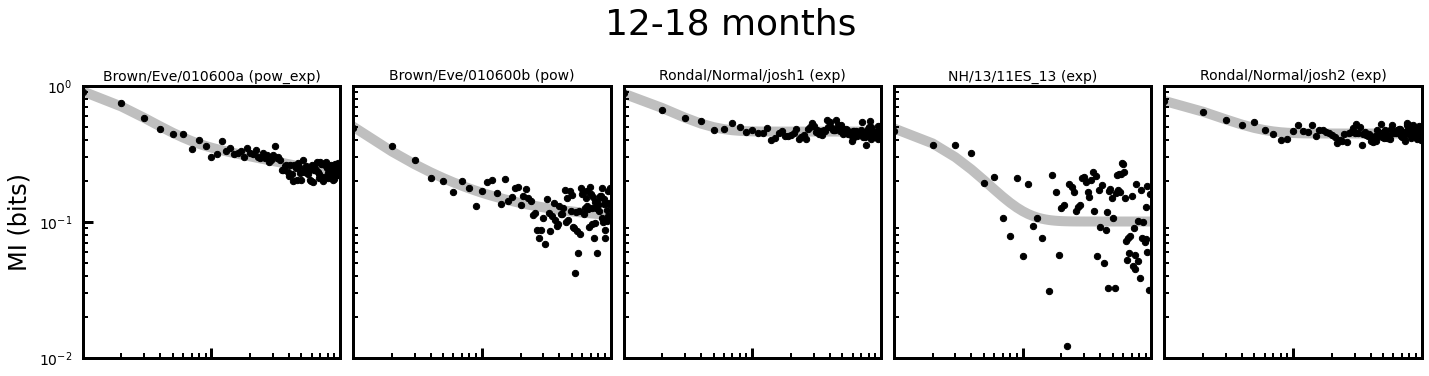

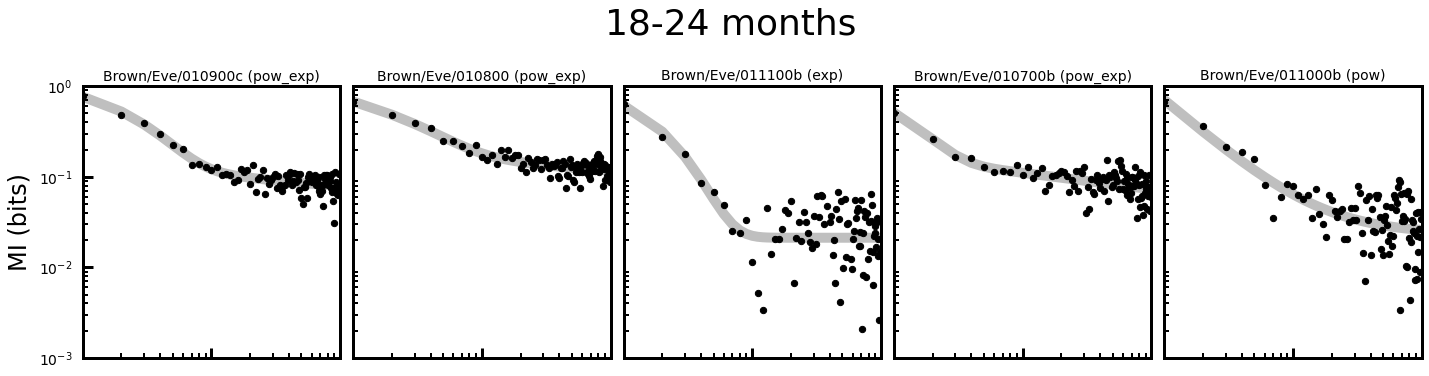

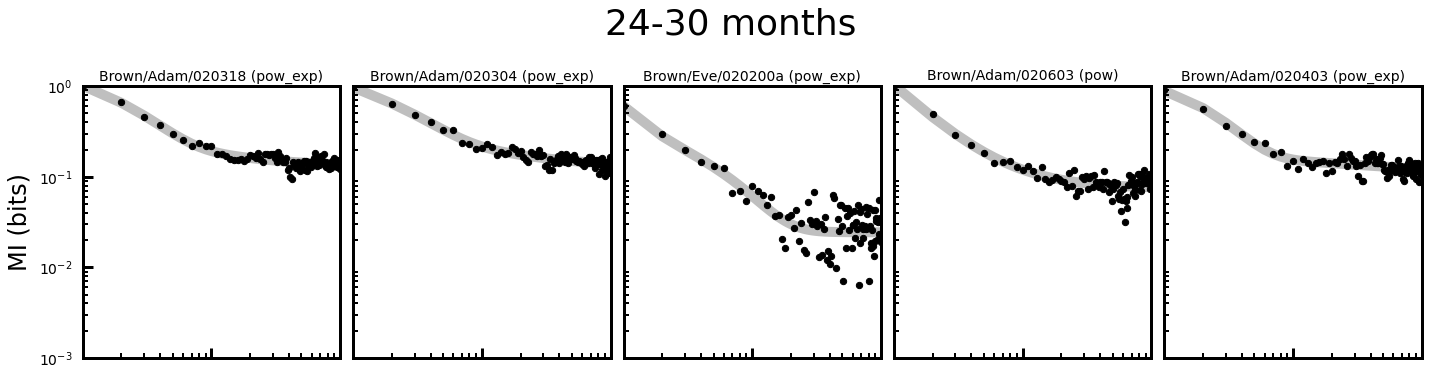

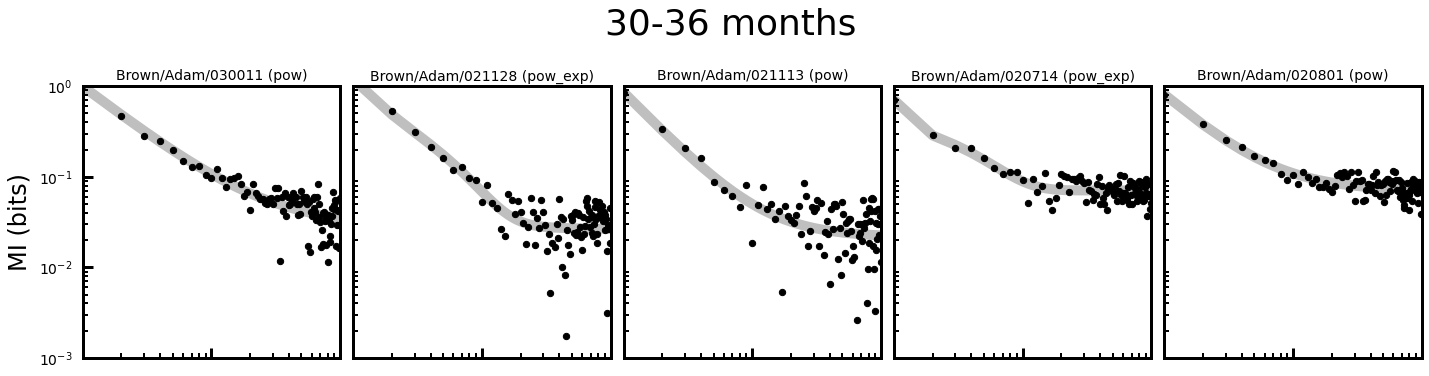

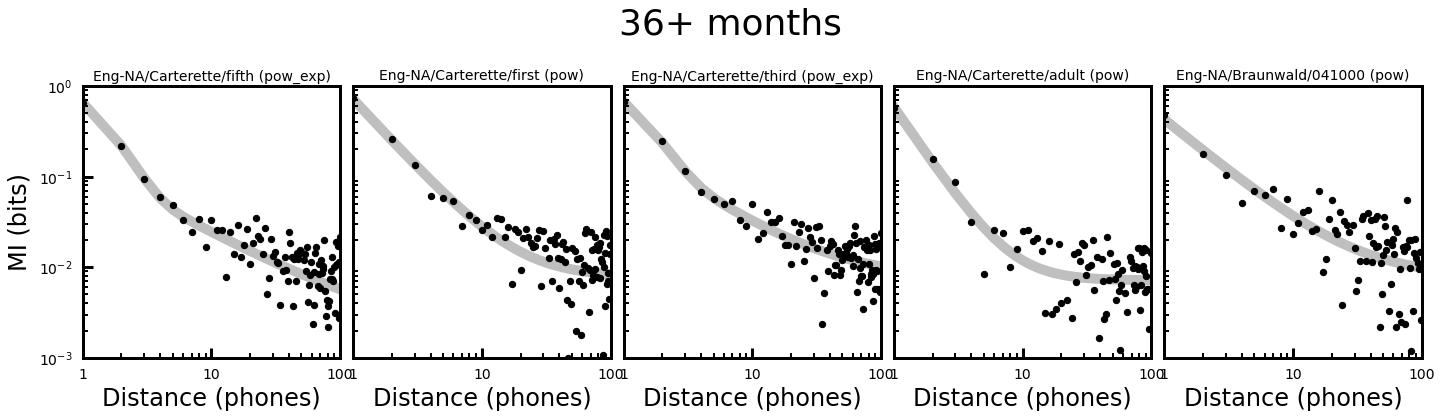

In [51]:
for [ac_low, ac_high] in age_cohorts:
    print(ac_low, ac_high)
    fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(24, 5))
    MI_DF_cohort = MI_DF[MI_DF.age_cohort_low == ac_low]
    for axi, (idx, row) in enumerate(MI_DF_cohort.iterrows()):
        if axi > 4: continue
        ax = axs.flatten()[axi]

        color = "k"
        sig = np.array(row.MI - row.shuff_MI)
        distances = row.distances
        dist_mask = distances < 100
        
        distances = distances[dist_mask]
        sig = sig[dist_mask]
        
        sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
        sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                            sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

        if axi in [0, 5]:
            ax.set_ylabel("MI (bits)", labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff, 0.5)

        distances_model = np.logspace(0, np.log10(distances[-1]), base=10, num=1000)

        # plot real data
        ax.scatter(distances, sig, alpha=1, s=40, color=color)

        if row.bestfitmodel == "pow_exp":
            y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)

        elif row.bestfitmodel == "exp":
            y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)

        elif row.bestfitmodel == "pow":
            y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)

        # plot modelled data
        ax.plot(distances, y_model, alpha=0.25, lw=10, color=color)

        
        ax.set_xlim([distances[0], distances[-1]])
        sig_lims[0] = np.log(10e-6)  #
        ax.set_ylim([1e-3, 1])
        ax.tick_params(which="both", direction="in", labelsize=14, pad=10)
        ax.tick_params(which="major", length=10, width=3)
        ax.tick_params(which="minor", length=5, width=2)
        ax.set_xscale("log", basex=10)
        ax.set_yscale("log", basey=10)
        ax.set_xticks([])
        for axis in ["top", "bottom", "left", "right"]:
            ax.spines[axis].set_linewidth(3)
            ax.spines[axis].set_color("k")

        if axi != 0:
            ax.set_yticks([])
    
        if ac_low == 3:
            ax.set_xticks([1,10,100])
            ax.set_xticklabels(['1','10','100'])
            ax.set_xlabel("Distance (phones)", labelpad=5, fontsize=24)
        else:
            ax.set_xticks([1,10,100])
            ax.set_xticklabels([])
        
        ax.set_title(
            "{} ({})".format(
                '/'.join(row.xml_loc[0].split("/")[-3:])[:-4], row.bestfitmodel
            ),
            fontsize=14,
        )
        if ac_low == 1:
            ax.set_ylim([1e-2, 1])
            
            
    fig.subplots_adjust(wspace = 0.05)
    if ac_low == 3:
            fig.suptitle("36+ months", fontsize=36, y=1.1)
    else:
        fig.suptitle("{}-{} months".format(int(ac_low*12), int(12*ac_high)), fontsize=36, y=1.1)
        
    

In [52]:
np.max(MI_DF[MI_DF.dataset == 'Gillam'].n_words)

1511